## Imports

In [1]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from ROOT import TLorentzVector,TGenPhaseSpace,TFile,TH2D,TCanvas,TTree,TH1F,TGraphErrors,TH2F,gStyle,TText,TLatex
import random
from scipy.interpolate import LinearNDInterpolator

Welcome to JupyROOT 6.26/00


## Event Parameters

In [2]:
events=100000 # Number of events
beamE=8.8   # Electron beam energy
days=50     # Days of beamtime
fprefix="test_py" # output file name prefix
batchID=0   # ID for batch

In [3]:
lumi = 1.2e37 * 0.5 * 1.0e-24 * 1.0e-9 * 3600.0 * 24 * days
print("Luminosity =", lumi/3600.0/24/days,"(events/nb/s)")
print("Integrated Luminosity =",lumi,"(events/nb)")

Luminosity = 5999.999999999999 (events/nb/s)
Integrated Luminosity = 25919999999.999992 (events/nb)


## File Creation

In [4]:
fname="./data/{}_beamE_{:.2f}_evts_{}_batch_{}.csv".format(fprefix,beamE,events,batchID)

## Constants

In [5]:
mJpsi = 3.0969
mD    = 0.938272   # mD is mProton
mE    = 0.000510999
m=mE
alpha_em = 1.0/137.036
couple = 4.0 * np.pi * alpha_em
GenPhase = TGenPhaseSpace()

## 4-Momentum of Particles

In [6]:
eIn, dIn, eOut, dOut, q, dilepton, ePlus, eMinus = TLorentzVector(), TLorentzVector(), TLorentzVector(), TLorentzVector(), TLorentzVector(), TLorentzVector(), TLorentzVector(), TLorentzVector()

## Functions

In [7]:
@njit
def Bremmstrahlung(kmin,kmax,beamE):
    ymin = kmin/beamE
    ymax = kmax/beamE
    y = random.uniform(ymin,ymax)
    flux = 0.01 * (4.0 / 3.0 * np.log(ymax / ymin) - 4.0 / 3.0 * (ymax - ymin) + 1.0 / 2.0 * (ymax * ymax - ymin * ymin))
    return flux, y*beamE

In [8]:
cthmin=-1 # subject to change depending on Pe
cthmax=1
def VirtualPhoton(kmin,kmax,beamE):
    Pe  = random.uniform(beamE-kmax,beamE-kmin)
    cthmin = (2*mD*mJpsi+mJpsi**2-2*mD*beamE+2*mD*Pe+2*beamE*Pe)/(2*beamE*Pe)
    cth = random.uniform(cthmin,cthmax)
    sth = np.sqrt(1-cth**2)
    phi = random.uniform(0,2*np.pi)
    eOut.SetXYZM(Pe * sth * np.cos(phi),Pe * sth * np.sin(phi),Pe * cth, mE)
    q=eIn-eOut
    W2 = (q+dIn)*(q+dIn)
    if(W2 < mD**2):
        return 0,TLorentzVector()
    Q2 = -q*q
    flux = np.sqrt((dIn*q)**2 + Q2 * mD**2)/np.sqrt((eIn*dIn)**2 - mE**2 * mD**2)
    amp = (2.0 * Q2 - 4.0 * mE**2) / (Q2**2)
    phase = eOut.P()**2/(2.0*eOut.E()*(2.0*np.pi)**3)
    volume = 2.0 * np.pi * np.abs(kmax-kmin) * (cthmax-cthmin)
    y = (dIn * q)/(dIn*eOut)
    gy = dIn.M() * np.sqrt(Q2)/(dIn * eIn)
    eps = (1.0 - y - 0.25 * gy * gy) / (1.0 - y + 0.5 * y * y + 0.25 * gy * gy)
    return couple * flux * amp * phase * volume / (1.0 - eps),q
#VirtualPhoton(kmin,kmax,beamE)

## Cross Section Model

In [9]:
@njit
def CE1(t,s,Mll2):
    return t*(s-mD**2)*(s-mD**2-Mll2+t)*(Mll2**2+6*Mll2*t+t**2+4*m**2*Mll2)+(Mll2-t)**2*(t**2*Mll2+mD**2*(Mll2+t)**2+4*m**2*mD**2*Mll2)
@njit
def CE2(t,s,Mll2):
    return -t*(s-mD**2)*(s-mD**2-Mll2+t)*(Mll2**2+t**2+4*m**2*(Mll2+2*t-2*m**2))+(Mll2-t)**2*(-mD**2*(Mll2**2+t**2)+2*m**2*(-t**2-2*mD**2*Mll2+4*m**2*mD**2))
@njit
def CM1(CE1,tauD,Mll2,t):
    return CE1-2*mD**2*(1+tauD)*(Mll2-t)**2*(Mll2**2+t**2+4*m**2*Mll2)
@njit
def CM2(CE2,tauD,Mll2,t):
    return CE2+2*mD**2*(1+tauD)*(Mll2-t)**2*(Mll2**2+t**2+4*m**2*(Mll2-t-2*m**2))

$Q [fm^{-1}]\rightarrow \left(Q[fm^{-1}]*10^{15}\frac{fm}{m}\right)^2\left(10^{28}m^2/b\right)*\left(0.001b/mb\right)*\left(0.389mb/GeV^{-2}\right)$

$[fm^{-1}] = 0.0389 GeV^{2}$

# Kinematics

In [10]:
@njit
def get_EC_ED_cth(EA,EB,MA,MB,MC,MD,t):
    # Assuming t > 0
    EC=(EA**2+2*EA*EB+EB**2+MC**2-MD**2)/(2*(EA+EB))
    ED=(EA**2+2*EA*EB+EB**2-MC**2+MD**2)/(2*(EA+EB))
    cth=(-t-MA**2-MD**2+2*EA*ED)/(2*np.sqrt(EA**2-MA**2)*np.sqrt(ED**2-MD**2))
    return EC,ED,cth

@njit
def get_tauD(t):
    return -t/(4*mD**2)
@njit
def get_s(Egamma):
    return mD**2+2*mD*Egamma

@njit
def get_cth_d_lab(Mll2,Egamma,t):
    tauD = get_tauD(t)
    s = get_s(Egamma)
    return (Mll2+2*(s+mD**2)*tauD)/(2*(s-mD**2)*np.sqrt(tauD*(1+tauD)))
@njit
def get_p_d_lab(t):
    return np.sqrt(((2*mD**2-t)/(2*mD))**2-mD**2)
@njit
def get_p_dilepton_lab(p_d_lab,cth_d_lab,Egamma):
    return (p_d_lab**2*np.sqrt(1-cth_d_lab**2)*np.abs(np.sqrt(1-cth_d_lab**2))+(Egamma-p_d_lab*cth_d_lab)**2)/np.sqrt(Egamma**2-2*Egamma*p_d_lab*cth_d_lab+p_d_lab**2)
@njit
def get_cth_dilepton_lab(p_d_lab,cth_d_lab,Egamma):
    return (Egamma-p_d_lab*cth_d_lab)/np.sqrt(Egamma**2-2*Egamma*p_d_lab*cth_d_lab+p_d_lab**2)

@njit
def get_beta(Mll2):
    return np.sqrt(1-4*m**2/Mll2)
@njit
def get_max_Mll2(Egamma,t):
    return 2*mD*Egamma+t-(Egamma/mD)*(2*mD**2-t-np.sqrt(t**2-4*mD**2*t))

@njit
def get_delta_T(tauD,t):
    # Approximation for small -t , large Mll2, large s
    return np.sqrt(-t*(1-tauD)-mD**2*tauD**2)
@njit
def get_delta_T2(s,Mll2,t,r):
    r0 = np.sqrt((s-mD**2)**2)
    cth_cm = (2 * s * (t - 2 * mD * mD) + (s + mD * mD)*(s + mD * mD - Mll2)) / (r0 * r)
    sth_cm = np.sqrt(1-cth_cm**2)
    return sth_cm*r/(2*np.sqrt(s))

# Form Factors

In [11]:
conv = 0.197327
a1,a2,a3,a4,als1,als2,als3,als4 = 1.57057 * conv**2, 12.23792 * conv**2, -42.04576 * conv**2, 27.92014 * conv**2, 1.52501 * conv**2, 8.75139 * conv**2,  15.97777 * conv**2, 23.20415* conv**2
b1,b2,b3,b4,bes1,bes2,bes3,bes4 = 0.07043 * conv, 0.14443 * conv, -0.27343 * conv, 0.05856 * conv, 43.67795 * conv**2, 30.05435 * conv**2, 16.43075 * conv**2,  2.80716* conv**2
c1,c2,c3,c4,gas1,gas2,gas3,gas4 = -0.16577, 0.27557 ,  -0.05382 , -0.05598 ,  1.87055 * conv**2, 14.95683 * conv**2,  28.04312 * conv**2, 41.12940* conv**2
@njit
def get_g0_g1_g2(Q2):
    g0 = a1/(als1+Q2)+a2/(als2+Q2)+a3/(als3+Q2)+a4/(als4+Q2)
    g1 = np.sqrt(Q2)*(b1/(bes1+Q2)+b2/(bes2+Q2)+b3/(bes3+Q2)+b4/(bes4+Q2))
    g2 = Q2 * (c1/(gas1+Q2)+c2/(gas2+Q2)+c3/(gas3+Q2)+c4/(gas4+Q2))
    return g0,g1,g2
@njit
def get_GC_GQ_GM(t):
    #t_fm = t/0.0389 # GeV^2 --> fm^-1
    tau = get_tauD(t)
    g0,g1,g2 = get_g0_g1_g2(-t)
    GC = 1/(1-t/4/0.807)**4/(2*tau+1)*((1-2/3*tau)*g0+8/3*np.sqrt(2*tau)*g1+2/3*(2*tau-1)*g2)
    GQ = 1/(1-t/4/0.807)**4/(2*tau+1)*(-g0+np.sqrt(2/tau)*g1-(tau+1)/tau*g2)
    GM = 1/(1-t/4/0.807)**4/(2*tau+1)*(2*g0+2*(2*tau-1)/np.sqrt(2*tau)*g1-2*g2)
    return GC,GQ,GM

# Cross Section

In [12]:
@njit
def get_dsigma_dt_dMll2(t,Egamma,Mll2):
    B = get_beta(Mll2)
    s = get_s(Egamma)
    tauD = get_tauD(t)
    ce1 = CE1(t,s,Mll2)
    ce2 = CE2(t,s,Mll2)
    cm1 = CM1(ce1,tauD,Mll2,t)
    cm2 = CM2(ce2,tauD,Mll2,t)
    CE = ce1 + (ce2/B)*np.log((1+B)/(1-B))
    CM = cm1 + (cm2/B)*np.log((1+B)/(1-B))
    GC,GQ,GM = get_GC_GQ_GM(t)
    factor1 = (4*alpha_em**3*B)/((s-mD**2)**2*t**2*(Mll2-t)**4)
    factor2 = (CE*(GC**2+8/9*tauD**2*GQ**2)+CM*2/3*tauD*GM**2)
    return factor1*factor2*(0.389379*10**6) # nb/GeV^4
@njit
def get_dsigma_dt_dMll2_dcosth(t,Egamma,Mll2,theta,phi):
    beta = get_beta(Mll2)
    s = get_s(Egamma)
    tauD = get_tauD(t)
    r = np.sqrt((s-mD**2-Mll2)**2-4*mD**2*Mll2)
    deltaT = get_delta_T2(s,Mll2,t,r)
    a = beta * r * np.cos(theta)
    b = beta * ((Mll2*(s-mD**2-Mll2)+t*(s-mD**2+Mll2))/r)*np.cos(theta)-beta*((2*(s-mD**2)*np.sqrt(Mll2)*deltaT)/r)*np.sin(theta)*np.cos(phi)
    L = ((Mll2-t)**2-b**2)/4
    A = (s-mD**2)**2*deltaT**2-t*a*(a+b)-mD**2*b**2-t*(4*mD**2-t)*Mll2+mE**2/L*(((Mll2-t)*(a+b)-(s-mD**2)*b)**2+t*(4*mD**2-t)*(Mll2-t)**2)
    B = (Mll2+t)**2 + b**2 + 8 * mE**2 * Mll2 - 4*mE**2*(t+2*mE**2)/L*(Mll2-t)**2
    F1p = (1. / ((1 - t / 0.71)*(1 - t / 0.71)))*(1 / (1 - t / (4. * mD * mD)))*(1 - 2.79 * t / (4 * mD * mD))
    F2p = (1. / ((1 - t / 0.71)*(1 - t / 0.71)))*(1 / (1 - t / (4. * mD * mD)))*(2.793 - 1)
    factor1 = (alpha_em**3*beta)/(4*np.pi*(s-mD**2)**2*(-t)*L)
    factor2 = (F1p**2-t/4/mD**2*F2p**2)*A/(-t)+(F1p+F2p)**2*B/2
    #print("a = ",a)
    #print("b = ",b)
    #print("F1p,F2p = ", F1p, ",",F2p)
    #print("L = ",L)
    #print("A_BH = ",A)
    #print("B_BH = ",B)
    return factor1*factor2*(0.389379*10**6) # nb/GeV^4

In [13]:
get_dsigma_dt_dMll2_dcosth(-1.22015,7.75893,5.85444,1.0633,3.076)*1000

11.285012382041064

## Acceptance

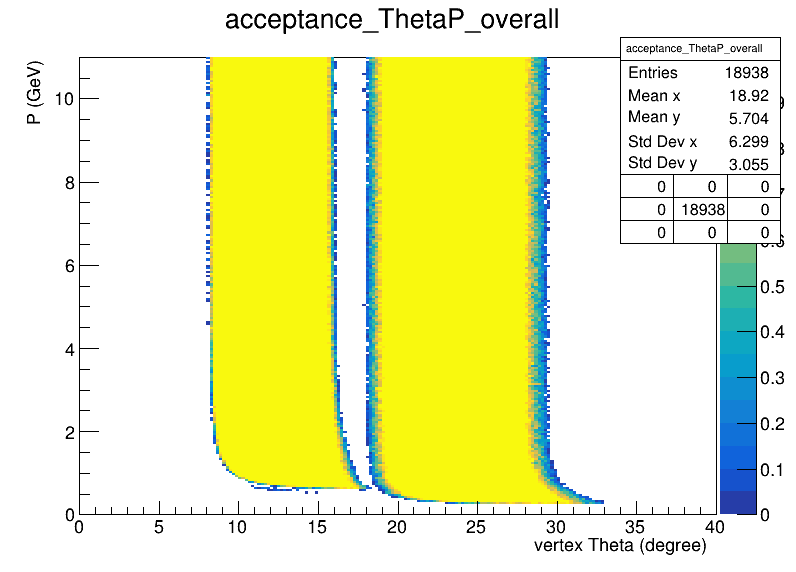

In [14]:
facc_solid = TFile("acceptance/acceptance_solid_JPsi_electron_target315_output.root","r")
acc_ele_solid = facc_solid.Get("acceptance_ThetaP_overall")
c=TCanvas("c","c",800,600)
acc_ele_solid.Draw("colz")
c.Draw()

In [15]:
# Does this electron/positron get measured?
def acc_e(P):
    binx = acc_ele_solid.GetXaxis().FindBin(P.Theta()*180.0/np.pi)
    biny = acc_ele_solid.GetYaxis().FindBin(P.P())
    return acc_ele_solid.GetBinContent(binx,biny)

def acc_D(P):
    # theta=P.Theta()*180.0/np.pi
    # momentum=P.P()
    # if(theta > 8.0 and theta < 15.0 and momentum < 10):
    #    return 1
    #elif(theta > 15.0 and theta < 26.0 and momentum < 6):
    #    return 1Duke
    #else:
    #    return 0
    binx = acc_ele_solid.GetXaxis().FindBin(P.Theta()*180.0/np.pi)
    biny = acc_ele_solid.GetYaxis().FindBin(P.P())
    return acc_ele_solid.GetBinContent(binx,biny)

# Smearing

In [16]:
fres_electron_solid = TFile("acceptance/JPsi_electron_resolution_2d.root","READ")
fres_positron_solid = TFile("acceptance/JPsi_electron_resolution_2d.root","READ")
fres_proton_solid = TFile("acceptance/JPsi_proton_resolution_2d.root","READ")
res_electron_solid_p = fres_electron_solid.Get("p_resolution")
res_positron_solid_p = fres_positron_solid.Get("p_resolution")
res_proton_solid_p = fres_proton_solid.Get("p_resolution")
res_electron_solid_th = fres_electron_solid.Get("theta_resolution")
res_positron_solid_th = fres_positron_solid.Get("theta_resolution")
res_proton_solid_th = fres_proton_solid.Get("theta_resolution")
res_electron_solid_phi = fres_electron_solid.Get("phi_resolution")
res_positron_solid_phi = fres_positron_solid.Get("phi_resolution")
res_proton_solid_phi = fres_proton_solid.Get("phi_resolution")
res_electron_solid_p.Scale(1.5)
res_positron_solid_p.Scale(1.5)
res_proton_solid_p.Scale(1.5)
res_electron_solid_th.Scale(1.5)
res_positron_solid_th.Scale(1.5)
res_proton_solid_th.Scale(1.5)
res_electron_solid_phi.Scale(1.5)
res_positron_solid_phi.Scale(1.5)
res_proton_solid_phi.Scale(1.5)

In [17]:
def get_smear_m_vm_gammaE(ep,em,d):
    pep = ep.P()
    pem = em.P()
    pd  = d.P()
    thep = ep.Theta()
    them = em.Theta()
    thd  = d.Theta()
    phiep= ep.Phi()
    phiem= em.Phi()
    phid = d.Phi()
    dpep = res_positron_solid_p.GetBinContent(res_positron_solid_p.FindBin(pep,thep*180.0/np.pi))/100.0
    dpem = res_electron_solid_p.GetBinContent(res_electron_solid_p.FindBin(pem,them*180.0/np.pi))/100.0
    dpd  = res_proton_solid_p.GetBinContent(res_proton_solid_p.FindBin(pd,thd*180.0/np.pi))/100.0
    dthep = res_positron_solid_th.GetBinContent(res_positron_solid_th.FindBin(pep,thep*180.0/np.pi))/100.0
    dthem = res_electron_solid_th.GetBinContent(res_electron_solid_th.FindBin(pem,them*180.0/np.pi))/100.0
    dthd  = res_proton_solid_th.GetBinContent(res_proton_solid_th.FindBin(pd,thd*180.0/np.pi))/100.0
    dphiep = res_positron_solid_phi.GetBinContent(res_positron_solid_phi.FindBin(pep,thep*180.0/np.pi))/100.0
    dphiem = res_electron_solid_phi.GetBinContent(res_electron_solid_phi.FindBin(pem,them*180.0/np.pi))/100.0
    dphid    = res_proton_solid_phi.GetBinContent(res_proton_solid_phi.FindBin(pd,thd*180.0/np.pi))/100.0
    pepprime = pep*np.random.normal(1,dpep)
    pemprime = pem*np.random.normal(1,dpem)
    pdprime  = pd *np.random.normal(1,dpd )
    thepprime = thep*np.random.normal(1,dthep)
    themprime = them*np.random.normal(1,dthem)
    thdprime  = thd *np.random.normal(1,dthd )
    phiepprime = phiep*np.random.normal(1,dphiep)
    phiemprime = phiem*np.random.normal(1,dphiem)
    phidprime  = phid *np.random.normal(1,dphid )
    lep = TLorentzVector(pepprime*np.sin(thepprime)*np.cos(phiepprime),pepprime*np.sin(thepprime)*np.sin(phiepprime),pepprime*np.cos(thepprime),np.sqrt(pepprime**2+mE**2))
    lem = TLorentzVector(pemprime*np.sin(themprime)*np.cos(phiemprime),pemprime*np.sin(themprime)*np.sin(phiemprime),pemprime*np.cos(themprime),np.sqrt(pemprime**2+mE**2))
    ld  = TLorentzVector (pdprime *np.sin(thdprime )*np.cos(phidprime ),pdprime *np.sin(thdprime )*np.sin(phidprime ),pdprime *np.cos(thdprime),np.sqrt(pdprime**2+mD**2))
    return (lep+lem).M(),(lep+lem+ld-dIn).E()

In [18]:
def smear_e(e):
    p = e.P()
    th = e.Theta()
    phi= e.Phi()
    dp = res_positron_solid_p.GetBinContent(res_positron_solid_p.FindBin(p,th*180.0/np.pi))/100.0
    dth = res_positron_solid_th.GetBinContent(res_positron_solid_th.FindBin(p,th*180.0/np.pi))/100.0
    dphi = res_positron_solid_phi.GetBinContent(res_positron_solid_phi.FindBin(p,th*180.0/np.pi))/100.0
    pprime = p*np.random.normal(1,dp)
    thprime = th*np.random.normal(1,dth)
    phiprime = phi*np.random.normal(1,dphi)
    return pprime,thprime,phiprime

# Cross Section Sketch

In [19]:
Mll2vals = np.linspace(0.03,0.08,1000)
dsVals_1 = get_dsigma_dt_dMll2(-0.01,0.65,Mll2vals)
dsVals_2 = get_dsigma_dt_dMll2(-0.02,0.65,Mll2vals)
dsVals_3 = get_dsigma_dt_dMll2(-0.03,0.65,Mll2vals)
tVals = np.linspace(-1,0,1000)
dsVals_4 = get_dsigma_dt_dMll2(tVals,4,mJpsi)
dsVals_5 = get_dsigma_dt_dMll2(tVals,5,mJpsi)
dsVals_6 = get_dsigma_dt_dMll2(tVals,6.5,mJpsi)
dsVals_7 = get_dsigma_dt_dMll2(tVals,7,mJpsi)
dsVals_8 = get_dsigma_dt_dMll2(tVals,8,mJpsi)

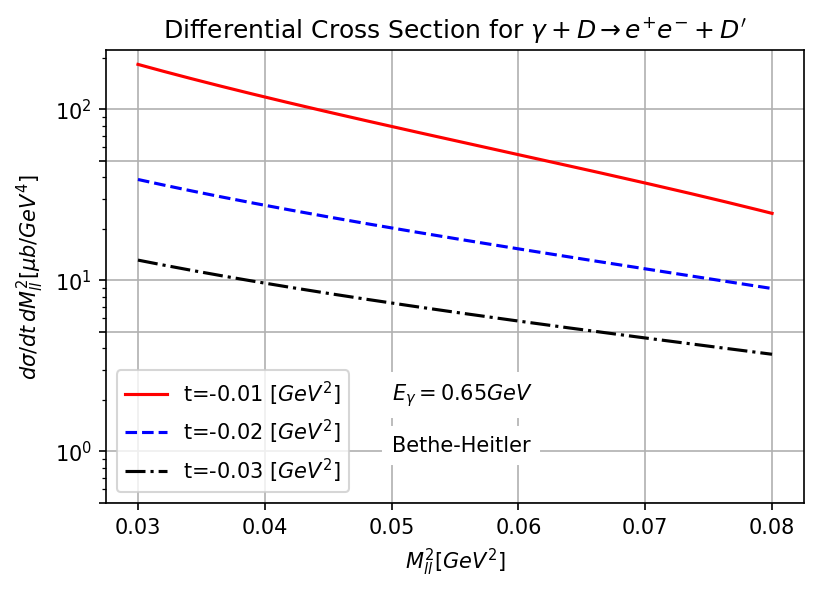

In [20]:
plt.figure(dpi=150)
plt.plot(Mll2vals,dsVals_1/1000,"r-",label="t=-0.01 $[GeV^{2}]$")
plt.plot(Mll2vals,dsVals_2/1000,"b--",label="t=-0.02 $[GeV^{2}]$")
plt.plot(Mll2vals,dsVals_3/1000,"k-.",label="t=-0.03 $[GeV^{2}]$")
plt.yscale("log")
plt.yticks([0.5,1,5,10,50,100])
plt.grid()
plt.title("Differential Cross Section for $\gamma + D\, → \,e^{+}e^{-} + D'$")
plt.xlabel("$M_{ll}^2[GeV^{2}]$")
plt.ylabel("$d\sigma/dt\,dM_{ll}^2 [\mu b/GeV^{4}]$")
plt.legend()
plt.text(0.05,2,"$E_{\gamma}=0.65 GeV$",backgroundcolor="white")
plt.text(0.05,1,"Bethe-Heitler",backgroundcolor="white")
plt.show()

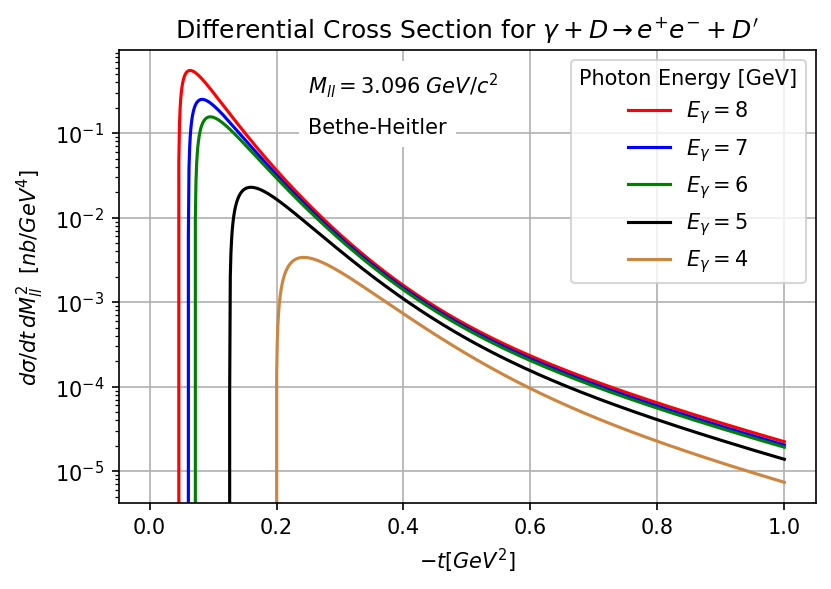

In [21]:
plt.figure(dpi=150)
plt.grid()
#label="Mll$^{2}$=2.5 $[GeV]$"
plt.plot(-tVals,dsVals_8,color="red",label="$E_{\gamma}=8$")
plt.plot(-tVals,dsVals_7,color="blue",label="$E_{\gamma}=7$")
plt.plot(-tVals,dsVals_6,color="green",label="$E_{\gamma}=6$")
plt.plot(-tVals,dsVals_5,color="black",label="$E_{\gamma}=5$")
plt.plot(-tVals,dsVals_4,color="peru",label="$E_{\gamma}=4$")

plt.yscale("log")
plt.title("Differential Cross Section for $\gamma + D\, → \,e^{+}e^{-} + D'$")
plt.xlabel("$-t[GeV^{2}]$")
plt.ylabel("$d\sigma/dt\,dM_{ll}^2 \;\;[nb/GeV^{4}]$")
plt.legend(title="Photon Energy [GeV]")
plt.text(0.25,0.3,"$M_{ll}=3.096\; GeV/c^{2}$",backgroundcolor="white")
plt.text(0.25,0.1,"Bethe-Heitler",backgroundcolor="white")
plt.show()

# Kinematic Limits

In [22]:
tmin,tmax=-1.5,-1.0
Mll2min,Mll2max=4,9
kmin=6   # Minimum photon energy
kmax=8   # Maximum photon energy

## Generator

In [27]:
%%time
# Create TFile
outFile=TFile("./data/{}_beamE_{:.2f}_evts_{}_batch_{}.root".format(fprefix,beamE,events,batchID),"RECREATE")
# Create TTree
outTree=TTree("tree","tree")
weight=np.array([0.0])
psf=np.array([0.0])
dsdtdMll2=np.array([0.0])
flux=np.array([0.0])
acc_ePlus=np.array([0.0])
acc_eMinus=np.array([0.0])
acc_dOut=np.array([0.0])
acc_photo=np.array([0.0])
gammaE_=np.array([0.0])
t_=np.array([0.0])
p_ePlus=np.array([0.0])
p_eMinus=np.array([0.0])
p_D=np.array([0.0])
th_ePlus=np.array([0.0])
th_eMinus=np.array([0.0])
th_ePlus_CM=np.array([0.0])
th_D=np.array([0.0])
m_vm=np.array([0.0])
th_vm=np.array([0.0])
smear_m_vm=np.array([0.0])
smear_gammaE=np.array([0.0])
outTree.Branch("weight",weight,"weight/D")
outTree.Branch("psf",psf,"psf/D")
outTree.Branch("dsdtdMll2",dsdtdMll2,"dsdtdMll2/D")
outTree.Branch("flux",flux,"flux/D")
outTree.Branch("acc_ePlus",acc_ePlus,"acc_ePlus/D")
outTree.Branch("acc_eMinus",acc_eMinus,"acc_eMinus/D")
outTree.Branch("acc_dOut",acc_dOut,"acc_dOut/D")
outTree.Branch("acc_photo",acc_photo,"acc_photo/D")
outTree.Branch("gammaE",gammaE_,"gammaE/D")
outTree.Branch("t",t_,"t/D")
outTree.Branch("p_ePlus",p_ePlus,"p_ePlus/D")
outTree.Branch("p_eMinus",p_eMinus,"p_eMinus/D")
outTree.Branch("p_D",p_D,"p_D/D")
outTree.Branch("th_ePlus",th_ePlus,"th_ePlus/D")
outTree.Branch("th_eMinus",th_eMinus,"th_eMinus/D")
outTree.Branch("th_ePlus_CM",th_ePlus_CM,"th_ePlus_CM/D")
outTree.Branch("th_D",th_D,"th_D/D")
outTree.Branch("m_vm",m_vm,"m_vm/D")
outTree.Branch("th_vm",th_vm,"th_vm/D")
outTree.Branch("smear_m_vm",smear_m_vm,"smear_m_vm/D")
outTree.Branch("smear_gammaE",smear_gammaE,"smear_gammaE/D")
success=0

for evt in range(events):
    # Set Initial Vectors
    eIn.SetPxPyPzE(0,0,np.sqrt(beamE**2-mE**2),beamE)
    dIn.SetXYZM(0,0,0,mD)
    
    # Do Bremmstrahlung
    weight[0], gammaE = Bremmstrahlung(kmin,kmax,beamE)
    flux[0] = weight[0]
    q.SetPxPyPzE(0,0,gammaE,gammaE)
    
    # Get scattered electron
    eOut = eIn-q
      
    # Generate t from allowable range
    t = random.uniform(tmin,tmax)
    
    # Generate Mll2 from allowable range
    Mll2max0 = get_max_Mll2(gammaE,t)
    if(Mll2max<Mll2max0):
        Mll2max0=Mll2max
    Mll2 = random.uniform(Mll2min,Mll2max0)
    
    # Set Lab Frame TLorentzVectors
    
    phi=random.uniform(0,2*np.pi)
    pDeuteron = get_p_d_lab(t)
    cthDeuteron = get_cth_d_lab(Mll2,gammaE,t)
    pDilepton = get_p_dilepton_lab(pDeuteron,cthDeuteron,gammaE)
    cthDilepton = get_cth_dilepton_lab(pDeuteron,cthDeuteron,gammaE)
    
    dOut.SetPxPyPzE(pDeuteron*np.sqrt(1-cthDeuteron**2)*np.cos(phi),
                    pDeuteron*np.sqrt(1-cthDeuteron**2)*np.sin(phi),
                    pDeuteron*cthDeuteron,
                    np.sqrt(pDeuteron**2+mD**2))
    dilepton.SetPxPyPzE(-pDilepton*np.sqrt(1-cthDilepton**2)*np.cos(phi),
                        -pDilepton*np.sqrt(1-cthDilepton**2)*np.sin(phi),
                        pDilepton*cthDilepton,
                        np.sqrt(pDilepton**2+Mll2))
    
    # Boost into Dilepton and Decay It
    comBOOST = dilepton.BoostVector()
    dilepton.Boost(-comBOOST)
    GenPhase.SetDecay(dilepton,2,np.array([m,m]))
    GenPhase.Generate()
    ePlus,eMinus = GenPhase.GetDecay(0), GenPhase.GetDecay(1)
    theta,phi = ePlus.Theta(),ePlus.Phi()
    # Unboost
    dilepton.Boost(comBOOST)
    ePlus.Boost(comBOOST)
    eMinus.Boost(comBOOST)
    
    # Get dsdt of (gamma + D --> e-e+ + D)
    the_ds = get_dsigma_dt_dMll2_dcosth(t,gammaE,Mll2,theta,phi)
    
    weight[0] *= the_ds
    #dsdtdMll2[0] = get_dsigma_dt_dMll2(t,gammaE,Mll2)
    dsdtdMll2[0] = the_ds
    # Multiply by range of uniform integration
    weight[0] *= (tmax-tmin)*(Mll2max0-Mll2min)*4*np.pi
    psf[0] = (tmax-tmin)*(Mll2max0-Mll2min)*4*np.pi
    #psf[0] = (tmax-tmin)
    # Get acceptances of final state particles
    acc_ePlus[0] = acc_e(ePlus)
    acc_eMinus[0]= acc_e(eMinus)
    acc_dOut[0]  = acc_D(dOut)
    acc_photo[0]   = acc_ePlus[0]*acc_eMinus[0]
    gammaE_[0]   = gammaE
    t_[0]        = t
    p_ePlus[0]   = ePlus.P()
    p_eMinus[0]  = eMinus.P()
    p_D[0]       = dOut.P()
    th_ePlus[0]  = ePlus.Theta()*180.0/np.pi
    th_ePlus_CM[0] = theta*180.0/np.pi
    th_eMinus[0] = eMinus.Theta()*180.0/np.pi
    th_D[0]      = dOut.Theta()*180.0/np.pi
    m_vm[0]      = (ePlus+eMinus).M()
    th_vm[0]     = (ePlus+eMinus).Theta()*180.0/np.pi
    if(acc_ePlus[0]>0 and acc_eMinus[0]>0):
        smear_m_vm[0],smear_gammaE[0]=get_smear_m_vm_gammaE(ePlus,eMinus,dOut)
    else:
        smear_m_vm[0],smear_gammaE[0]=0.0,0.0
    # Save data to dfOut
    #   Record if the event was successfully simulated
    if(weight[0]>0.0):
        success+=1
        outTree.Fill()
print(success)
outFile.Write()
outFile.Close()

100000
CPU times: user 6.08 s, sys: 304 ms, total: 6.38 s
Wall time: 6.42 s


## Plotting

In [104]:
h1counts=TH1F("h1counts","h1counts",2,3,4)
h1counts.GetBinCenter(2)

3.75

Warning in <TROOT::Append>: Replacing existing TH1: h1counts (Potential memory leak).


In [81]:
Nbins=1
binXmin=3.0
binXmax=3.2
tg1=TGraphErrors(Nbins)
h1counts=TH1F("h1counts","h1counts",Nbins,binXmin,binXmax)
h1events=TH1F("h1events","h1events",Nbins,binXmin,binXmax)
outTree.Draw("m_vm>>h1counts","(abs(gammaE-8)<0.1)*(abs(-t-1.5)<0.1)","goff")
outTree.Draw("m_vm>>h1events","(abs(gammaE-8)<0.1)*dsdtdMll2*(abs(-t-1.5)<0.1)*4*pi","goff")
for BIN in range(h1counts.GetNbinsX()+1):
    if(h1counts.GetBinContent(BIN)<1 or BIN==0):
        continue
    x = h1events.GetBinCenter(BIN)
    y = h1events.GetBinContent(BIN)/h1counts.GetBinContent(BIN)
    tg1.SetPoint(BIN,x,y)
    tg1.SetPointError(BIN,0,0)
    print(x,y,h1counts.GetBinContent(BIN))
tg1.SetMarkerStyle(20)
tg1.GetXaxis().SetLimits(binXmin,binXmax)
tg1.GetYaxis().SetRangeUser(0.00000001,0.00001)
tg1.Draw("AP")
c.SetLogy()
c.Draw()

AttributeError: 'CPyCppyy_NoneType' object has no attribute 'Draw'

Warning in <TROOT::Append>: Replacing existing TH1: h1counts (Potential memory leak).


In [ ]:
get_dsigma_dt_dMll2(-1.5,8,3.1**2)

In [ ]:
h1 = TH1F("h1",";Dilepton Scattering Angle [deg];Events",50,0,20)
h2 = TH1F("h2",";Dilepton Scattering Angle [deg];Events",50,0,20)
outTree.Draw("th_vm>>h1","(t>-.6&&t<0)*weight*{}/{}".format(lumi,events))
h1.Draw("hist E1")
c.SetGrid()
gStyle.SetOptStat(0)
c.SetLogy(1)
c.Draw()

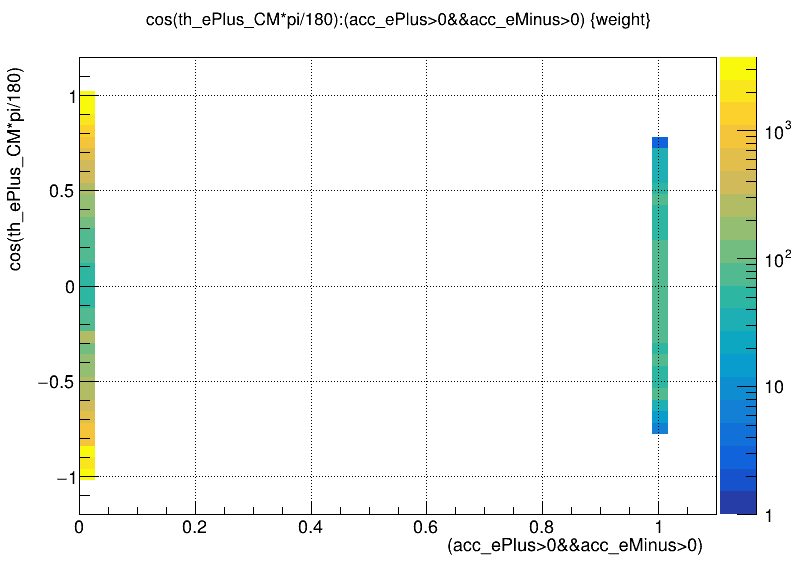

In [68]:
outTree.Draw("cos(th_ePlus_CM*pi/180):(acc_ePlus>0&&acc_eMinus>0)","weight","colz")
#outTree.Draw("th_ePlus_CM","weight")
c.SetLogy(0)
c.SetLogz(1)
c.Draw()

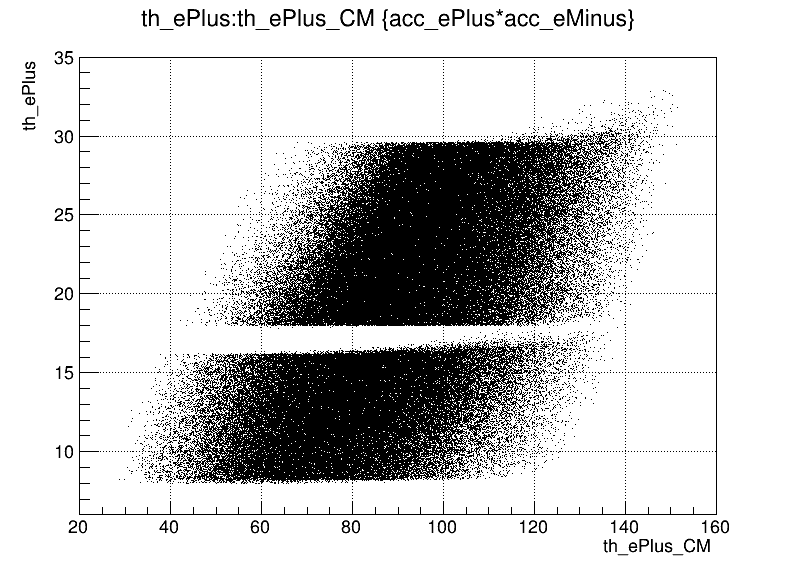

In [69]:
outTree.Draw("th_ePlus:th_ePlus_CM","acc_ePlus*acc_eMinus")
c.Draw()

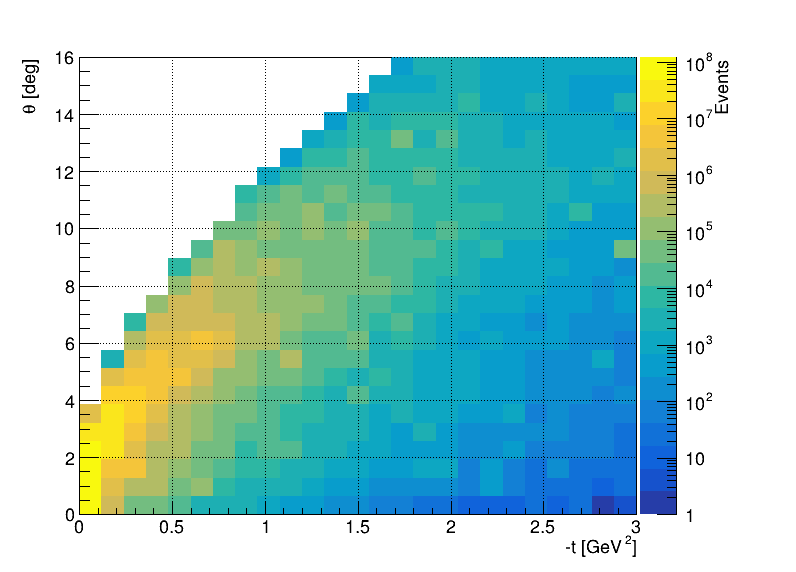

In [70]:
h = TH2F("h",";-t [GeV^{2}];#theta [deg];Events",25,0,3,25,0,16)
#h.GetZaxis().SetRangeUser(1e-8,1e3)
outTree.Draw("th_vm:-t>>h","weight*{}/{}".format(lumi,events),"colz")
c.SetRightMargin(0.2)
c.SetLogy(0)
c.SetLogz(1)
c.Draw()

0.06645366656275448


Warning in <TFile::Append>: Replacing existing TH1: h1counts (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1events (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1eventsacc (Potential memory leak).


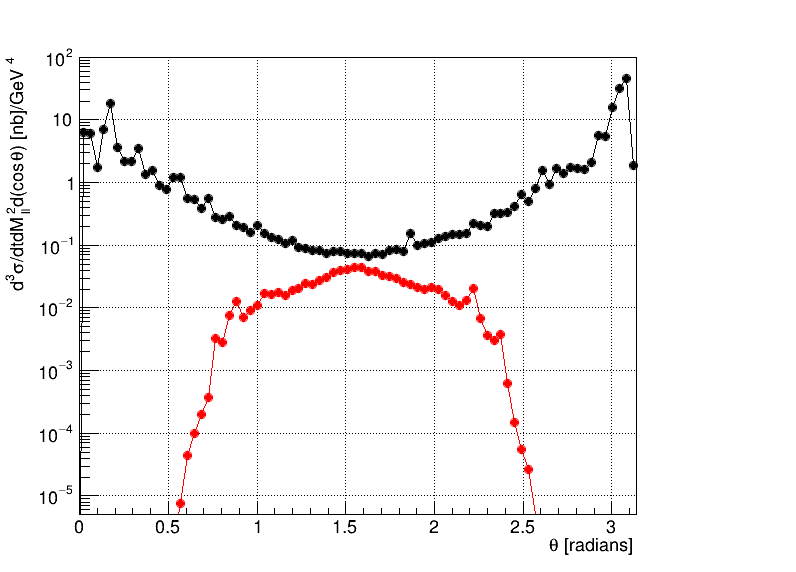

In [73]:
Nbins=80
binXmin=0
binXmax=3.14
tg1=TGraphErrors(Nbins)
tg2=TGraphErrors(Nbins)
h1counts=TH1F("h1counts","h1counts",Nbins,binXmin,binXmax)
h1events=TH1F("h1events","h1events",Nbins,binXmin,binXmax)
h1eventsacc=TH1F("h1eventsacc","h1eventsacc",Nbins,binXmin,binXmax)
outTree.Draw("th_ePlus_CM/180*pi>>h1counts","","goff")
outTree.Draw("th_ePlus_CM/180*pi>>h1events","dsdtdMll2*2*pi","goff")
outTree.Draw("th_ePlus_CM/180*pi>>h1eventsacc","dsdtdMll2*2*pi*acc_photo","goff")
minVal = 9999
for BIN in range(h1counts.GetNbinsX()+1):
    if(h1counts.GetBinContent(BIN)<1 or BIN==0):
        continue
    x = h1events.GetBinCenter(BIN)
    y = h1events.GetBinContent(BIN)/h1counts.GetBinContent(BIN)
    y2 = h1eventsacc.GetBinContent(BIN)/h1counts.GetBinContent(BIN)
    if(y<minVal):
        minVal=y
    tg1.SetPoint(BIN,x,y)
    tg1.SetPointError(BIN,0,0)
    tg2.SetPoint(BIN,x,y2)
    tg2.SetPointError(BIN,0,0)
tg1.SetMarkerStyle(20)
tg2.SetMarkerStyle(20)
tg2.SetLineColor(2)
tg2.SetMarkerColor(2)
tg1.GetXaxis().SetLimits(binXmin,binXmax)
tg1.GetYaxis().SetRangeUser(5e-6,100)
tg1.Draw("AP")
tg1.Draw("l same")
tg2.Draw("pl same")
tg1.SetTitle(";#theta [radians];d^{3}#sigma/dtdM_{ll}^{2}d(cos#theta) [nb]/GeV^{4}")
c.SetGrid()
c.SetLogy(1)
c.Draw()
print(minVal)

23432534.0


Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).


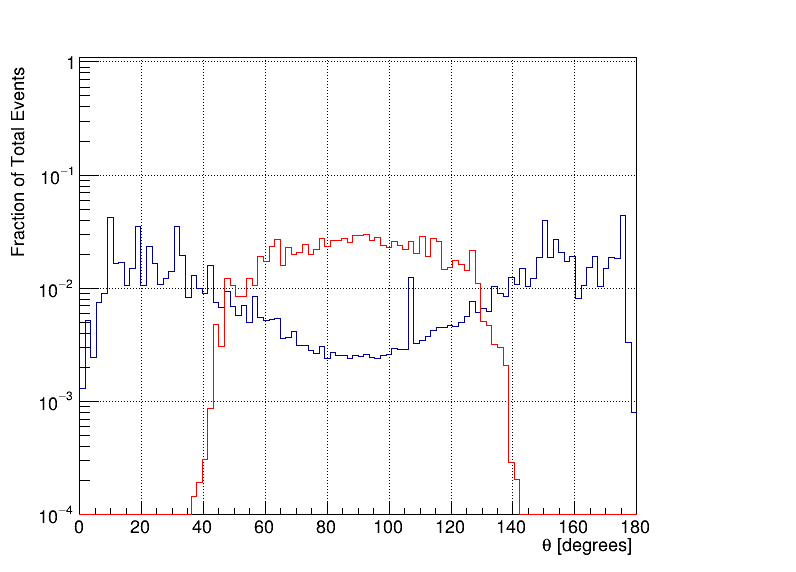

In [72]:
h = TH1F("h",";#theta [degrees];Fraction of Total Events",100,0,180)
h2 = TH1F("h2","h2",100,0,180)
outTree.Draw("th_ePlus_CM>>h","weight","goff")
outTree.Draw("th_ePlus_CM>>h2","acc_photo*weight","goff")
h.Scale(1/h.Integral())
h2.Scale(1/h2.Integral())
h.GetYaxis().SetRangeUser(1e-4,1.1)
h.Draw("hist")
h2.SetLineColor(2)
h2.Draw("hist same")
print(h1.GetBinContent(10))
c.SetLogy(1)
c.Draw()

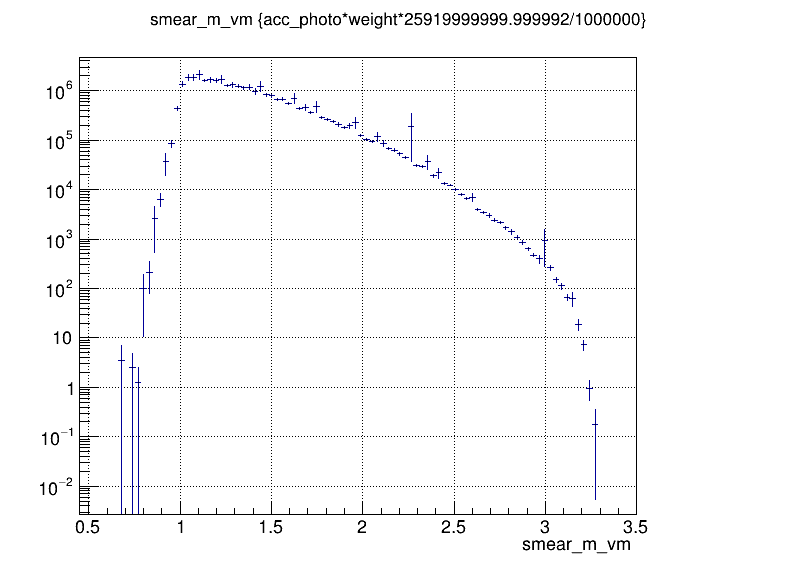

In [75]:
outTree.Draw("smear_m_vm","acc_photo*weight*{}/{}".format(lumi,events))
c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


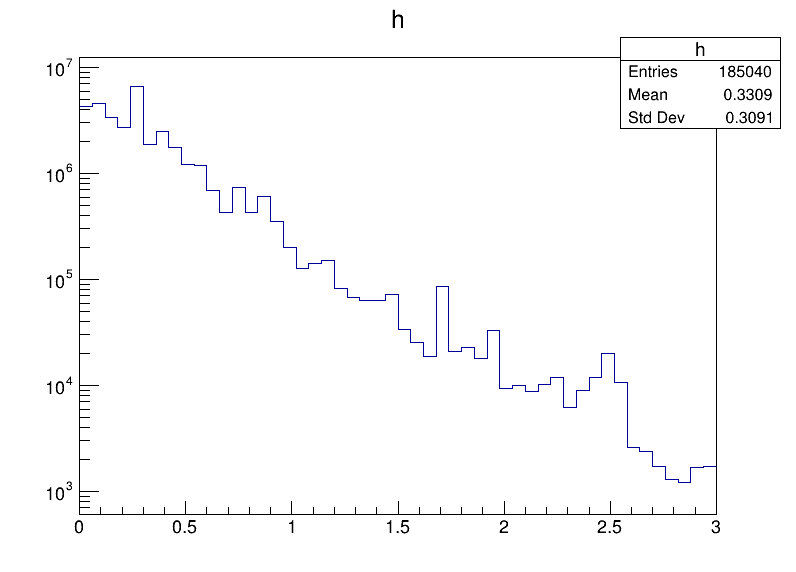

In [29]:
h=TH1F("h","h",50,0,3)
outTree.Draw("-t>>h","acc_photo*weight*{}/{}".format(lumi,events),"hist")
c.SetLogy(1)
c.Draw()

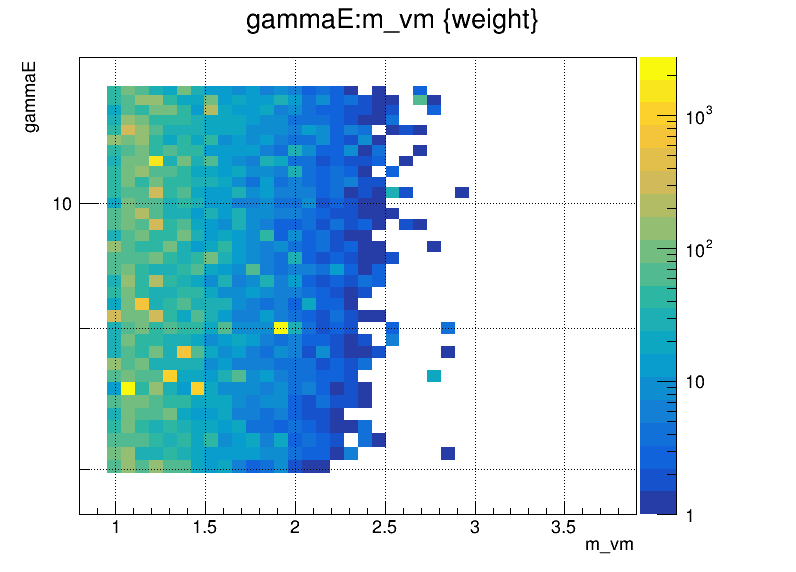

In [110]:
outTree.Draw("gammaE:m_vm","weight","colz")
c.Draw()

In [141]:
np.sqrt(get_max_Mll2(8.5,-3))

3.145251368430876

In [49]:
outTree.Print()

******************************************************************************
*Tree    :tree      : tree                                                   *
*Entries :   100000 : Total =        16861839 bytes  File  Size =   11314383 *
*        :          : Tree compression factor =   1.48                       *
******************************************************************************
*Br    0 :weight    : weight/D                                               *
*Entries :   100000 : Total  Size=     802904 bytes  File Size  =     757190 *
*Baskets :       25 : Basket Size=      32000 bytes  Compression=   1.06     *
*............................................................................*
*Br    1 :psf       : psf/D                                                  *
*Entries :   100000 : Total  Size=     802811 bytes  File Size  =     744088 *
*Baskets :       25 : Basket Size=      32000 bytes  Compression=   1.08     *
*...................................................

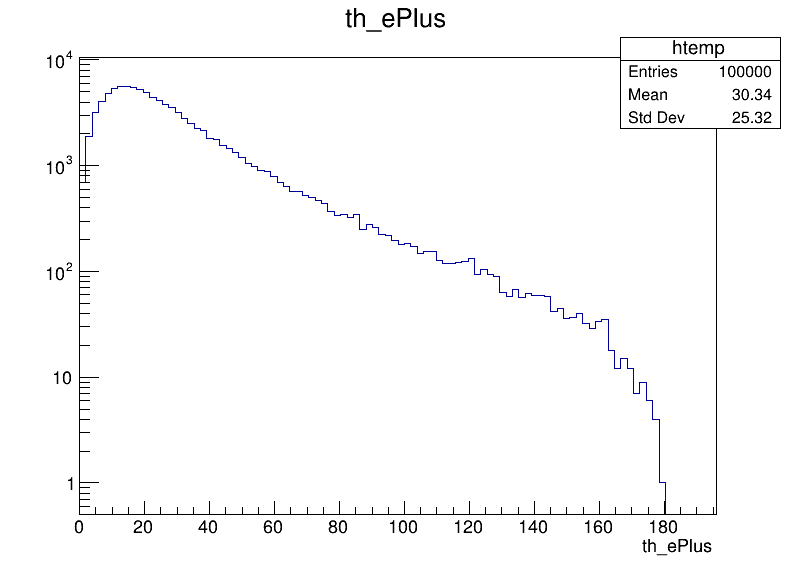

In [52]:
outTree.Draw("th_ePlus")
c.SetLogy(1)
c.Draw()

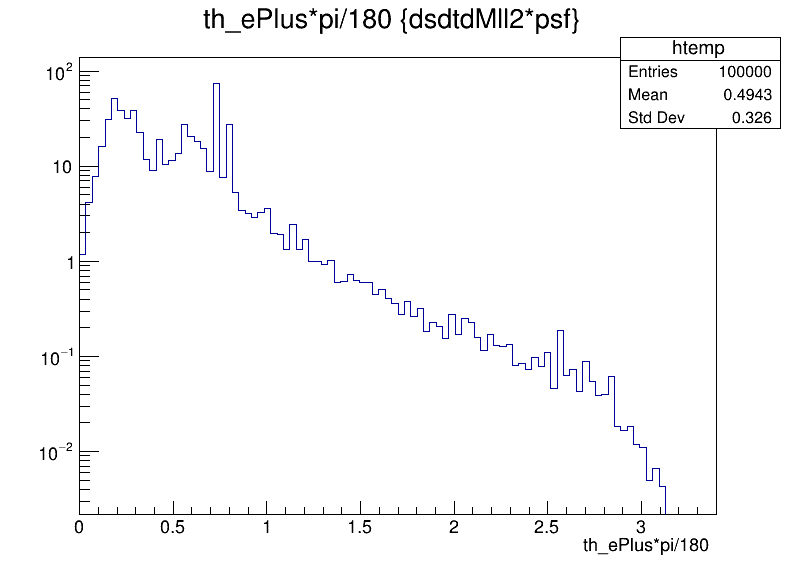

In [56]:
outTree.Draw("th_ePlus*pi/180","dsdtdMll2*psf","hist")
c.SetLogy(1)
c.Draw()